# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


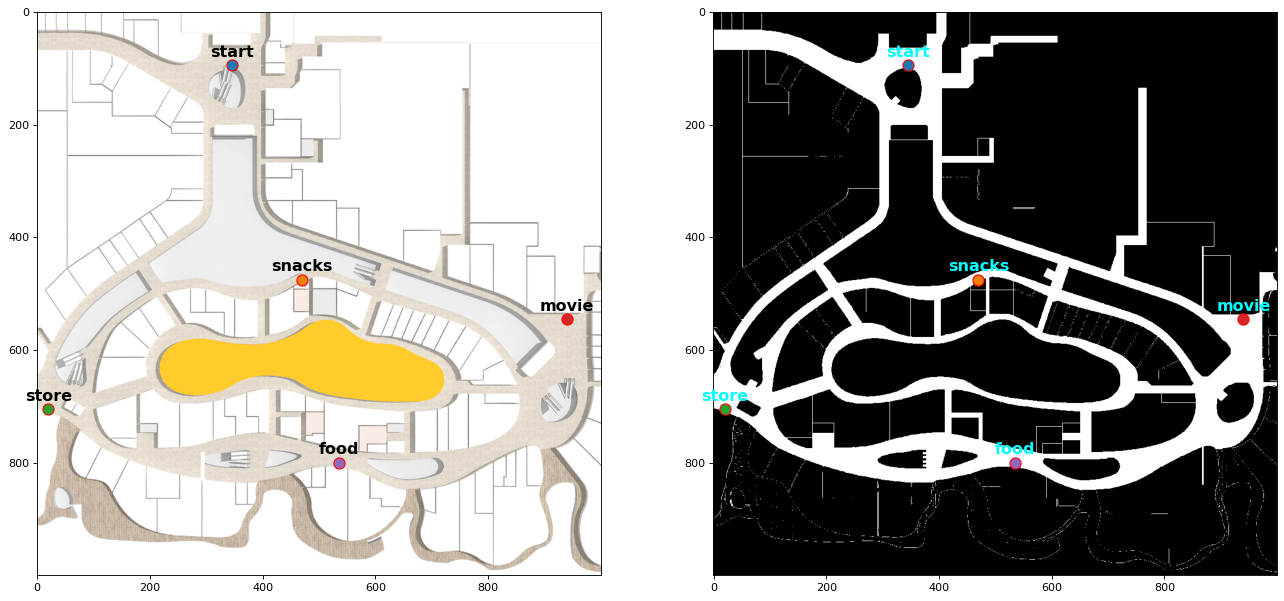

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [3]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [7]:
import numpy as np
import time
import heapq
from typing import List, Tuple, Set, Dict, Any
import matplotlib.pyplot as plt

def heuristic_manhattan(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    """
    manhattan distance heuristic function
    """
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

def heuristic_euclidean(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    """
    euclidean distance heuristic function
    """
    return np.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

def heuristic_chebyshev(a: Tuple[int, int], b: Tuple[int, int]) -> float:
    """
    chebyshev distance heuristic function
    """
    dx = abs(b[0] - a[0])
    dy = abs(b[1] - a[1])
    return max(dx, dy)

def get_neighbors(current: Tuple[int, int], grid: np.ndarray) -> List[Tuple[int, int]]:
    """
    get neighbors of the current position 8 directions
    Args:
        current: position (x,y)
        grid: grid map (255 for free space, 0 for obstacle)
    Returns:
        neighbors: list of neighbor positions
        costs: list of costs for each neighbor
    """
    neighbors = []
    costs = []
    # 8 directions
    directions = [(0,1), (-1,0), (0,-1), (1,0),
                 (-1,1), (1,1), (-1,-1), (1,-1)]
    
    for dx, dy in directions:
        new_x = current[0] + dx
        new_y = current[1] + dy
        
        # check if within bounds
        if 0 <= new_x < grid.shape[0] and 0 <= new_y < grid.shape[1]:
            # check if free space
            if grid[new_x, new_y] == 255:
                neighbors.append((new_x, new_y))
                # diagonal cost is 0.282, straight cost is 0.2
                cost = 0.282 if abs(dx) == 1 and abs(dy) == 1 else 0.2
                costs.append(cost)
    
    return neighbors, costs

def astar_with_heuristic(grid: np.ndarray, start: List[int], goal: List[int], 
                        heuristic_func) -> Tuple[List[Tuple[int, int]], float]:
    """
    A* algorithm with heuristic function
    Returns:
        path: path points [(x1,y1), (x2,y2),...]
        time: calculate time(ms)
    """
    start_time = time.time()
    start = tuple(start)
    goal = tuple(goal)
    
    if grid[start[0], start[1]] != 255 or grid[goal[0], goal[1]] != 255:
        return [], 0

    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while frontier:
        current = heapq.heappop(frontier)[1]
        
        if current == goal:
            break
            
        neighbors, costs = get_neighbors(current, grid)
        for next_pos, cost in zip(neighbors, costs):
            new_cost = cost_so_far[current] + cost
            
            if next_pos not in cost_so_far or new_cost < cost_so_far[next_pos]:
                cost_so_far[next_pos] = new_cost
                priority = new_cost + heuristic_func(next_pos, goal)
                heapq.heappush(frontier, (priority, next_pos))
                came_from[next_pos] = current

    if goal not in came_from:
        return [], 0
        
    path = []
    current = goal
    while current is not None:
        path.append(current)
        current = came_from[current]
    path.reverse()
    
    end_time = time.time()
    return path, (end_time - start_time) * 1000

def astar(grid: np.ndarray, start: List[int], goal: List[int]) -> List[Tuple[int, int]]:
    """
    A*
    Args:
        grid: grid map (255 for free space, 0 for obstacle)
        start: start position [x,y]
        goal: goal position [x,y]
    Returns:
        path: path points [(x1,y1), (x2,y2),...]
    """
    start = tuple(start)
    goal = tuple(goal)
    
    # check if start and goal are in free space
    if grid[start[0], start[1]] != 255 or grid[goal[0], goal[1]] != 255:
        print("start or goal is not in free space!")
        return []

    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while frontier:
        current = heapq.heappop(frontier)[1]
        
        if current == goal:
            break
            
        neighbors, costs = get_neighbors(current, grid)
        for next_pos, cost in zip(neighbors, costs):
            new_cost = cost_so_far[current] + cost
            
            if next_pos not in cost_so_far or new_cost < cost_so_far[next_pos]:
                cost_so_far[next_pos] = new_cost
                priority = new_cost + heuristic_manhattan(goal, next_pos)
                heapq.heappush(frontier, (priority, next_pos))
                came_from[next_pos] = current

    if goal not in came_from:
        print("goal not reachable!")
        return []
        
    # reconstruct path
    path = []
    current = goal
    while current is not None:
        path.append(current)
        current = came_from[current]
    path.reverse()
    
    return path

def plot_path(path: List[Tuple[int, int]]) -> None:
    """
    visualize the path
    Args:
        path: path points [(x1,y1), (x2,y2),...]
    """
    
    if path:
        path = np.array(path)
        plt.plot(path[:,0], path[:,1], 'r-', linewidth=2, label='Path')
    plt.legend(fontsize=12)
    plt.title("A* Path Planning Result", fontsize=14)
    plt.show()

    # A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

def calculate_path_length(path: List[Tuple[int, int]], resolution: float = 0.2) -> float:
    """
    calculate the length of the path
    Args:
        path: path points [(x1,y1), (x2,y2),...]
        resolution: map resolution (meters per pixel)
    Returns:
        path_length: length of the path (meters)
    """
    if not path:
        return 0.0
        
    path_length = 0.0
    path = np.array(path)
    
    # calculate the length of each segment
    for i in range(len(path)-1):
        dx = path[i+1][0] - path[i][0]
        dy = path[i+1][1] - path[i][1]
        segment_length = np.sqrt(dx*dx + dy*dy) * resolution
        path_length += segment_length
        
    return path_length



Path found from start to snacks:
- Steps: 623
- Length: 142.5 meters
- Time: 1185.92 ms

Path found from start to store:
- Steps: 653
- Length: 161.8 meters
- Time: 3862.07 ms

Path found from start to movie:
- Steps: 866
- Length: 207.8 meters
- Time: 664.24 ms

Path found from start to food:
- Steps: 981
- Length: 225.6 meters
- Time: 8860.12 ms

Path found from snacks to start:
- Steps: 657
- Length: 149.8 meters
- Time: 7197.74 ms

Path found from snacks to store:
- Steps: 523
- Length: 122.6 meters
- Time: 23.25 ms

Path found from snacks to movie:
- Steps: 589
- Length: 140.0 meters
- Time: 286.67 ms

Path found from snacks to food:
- Steps: 575
- Length: 130.9 meters
- Time: 3843.33 ms

Path found from store to start:
- Steps: 652
- Length: 163.2 meters
- Time: 1765.71 ms

Path found from store to snacks:
- Steps: 496
- Length: 118.0 meters
- Time: 35.77 ms

Path found from store to movie:
- Steps: 1026
- Length: 249.2 meters
- Time: 420.40 ms

Path found from store to food:
- 

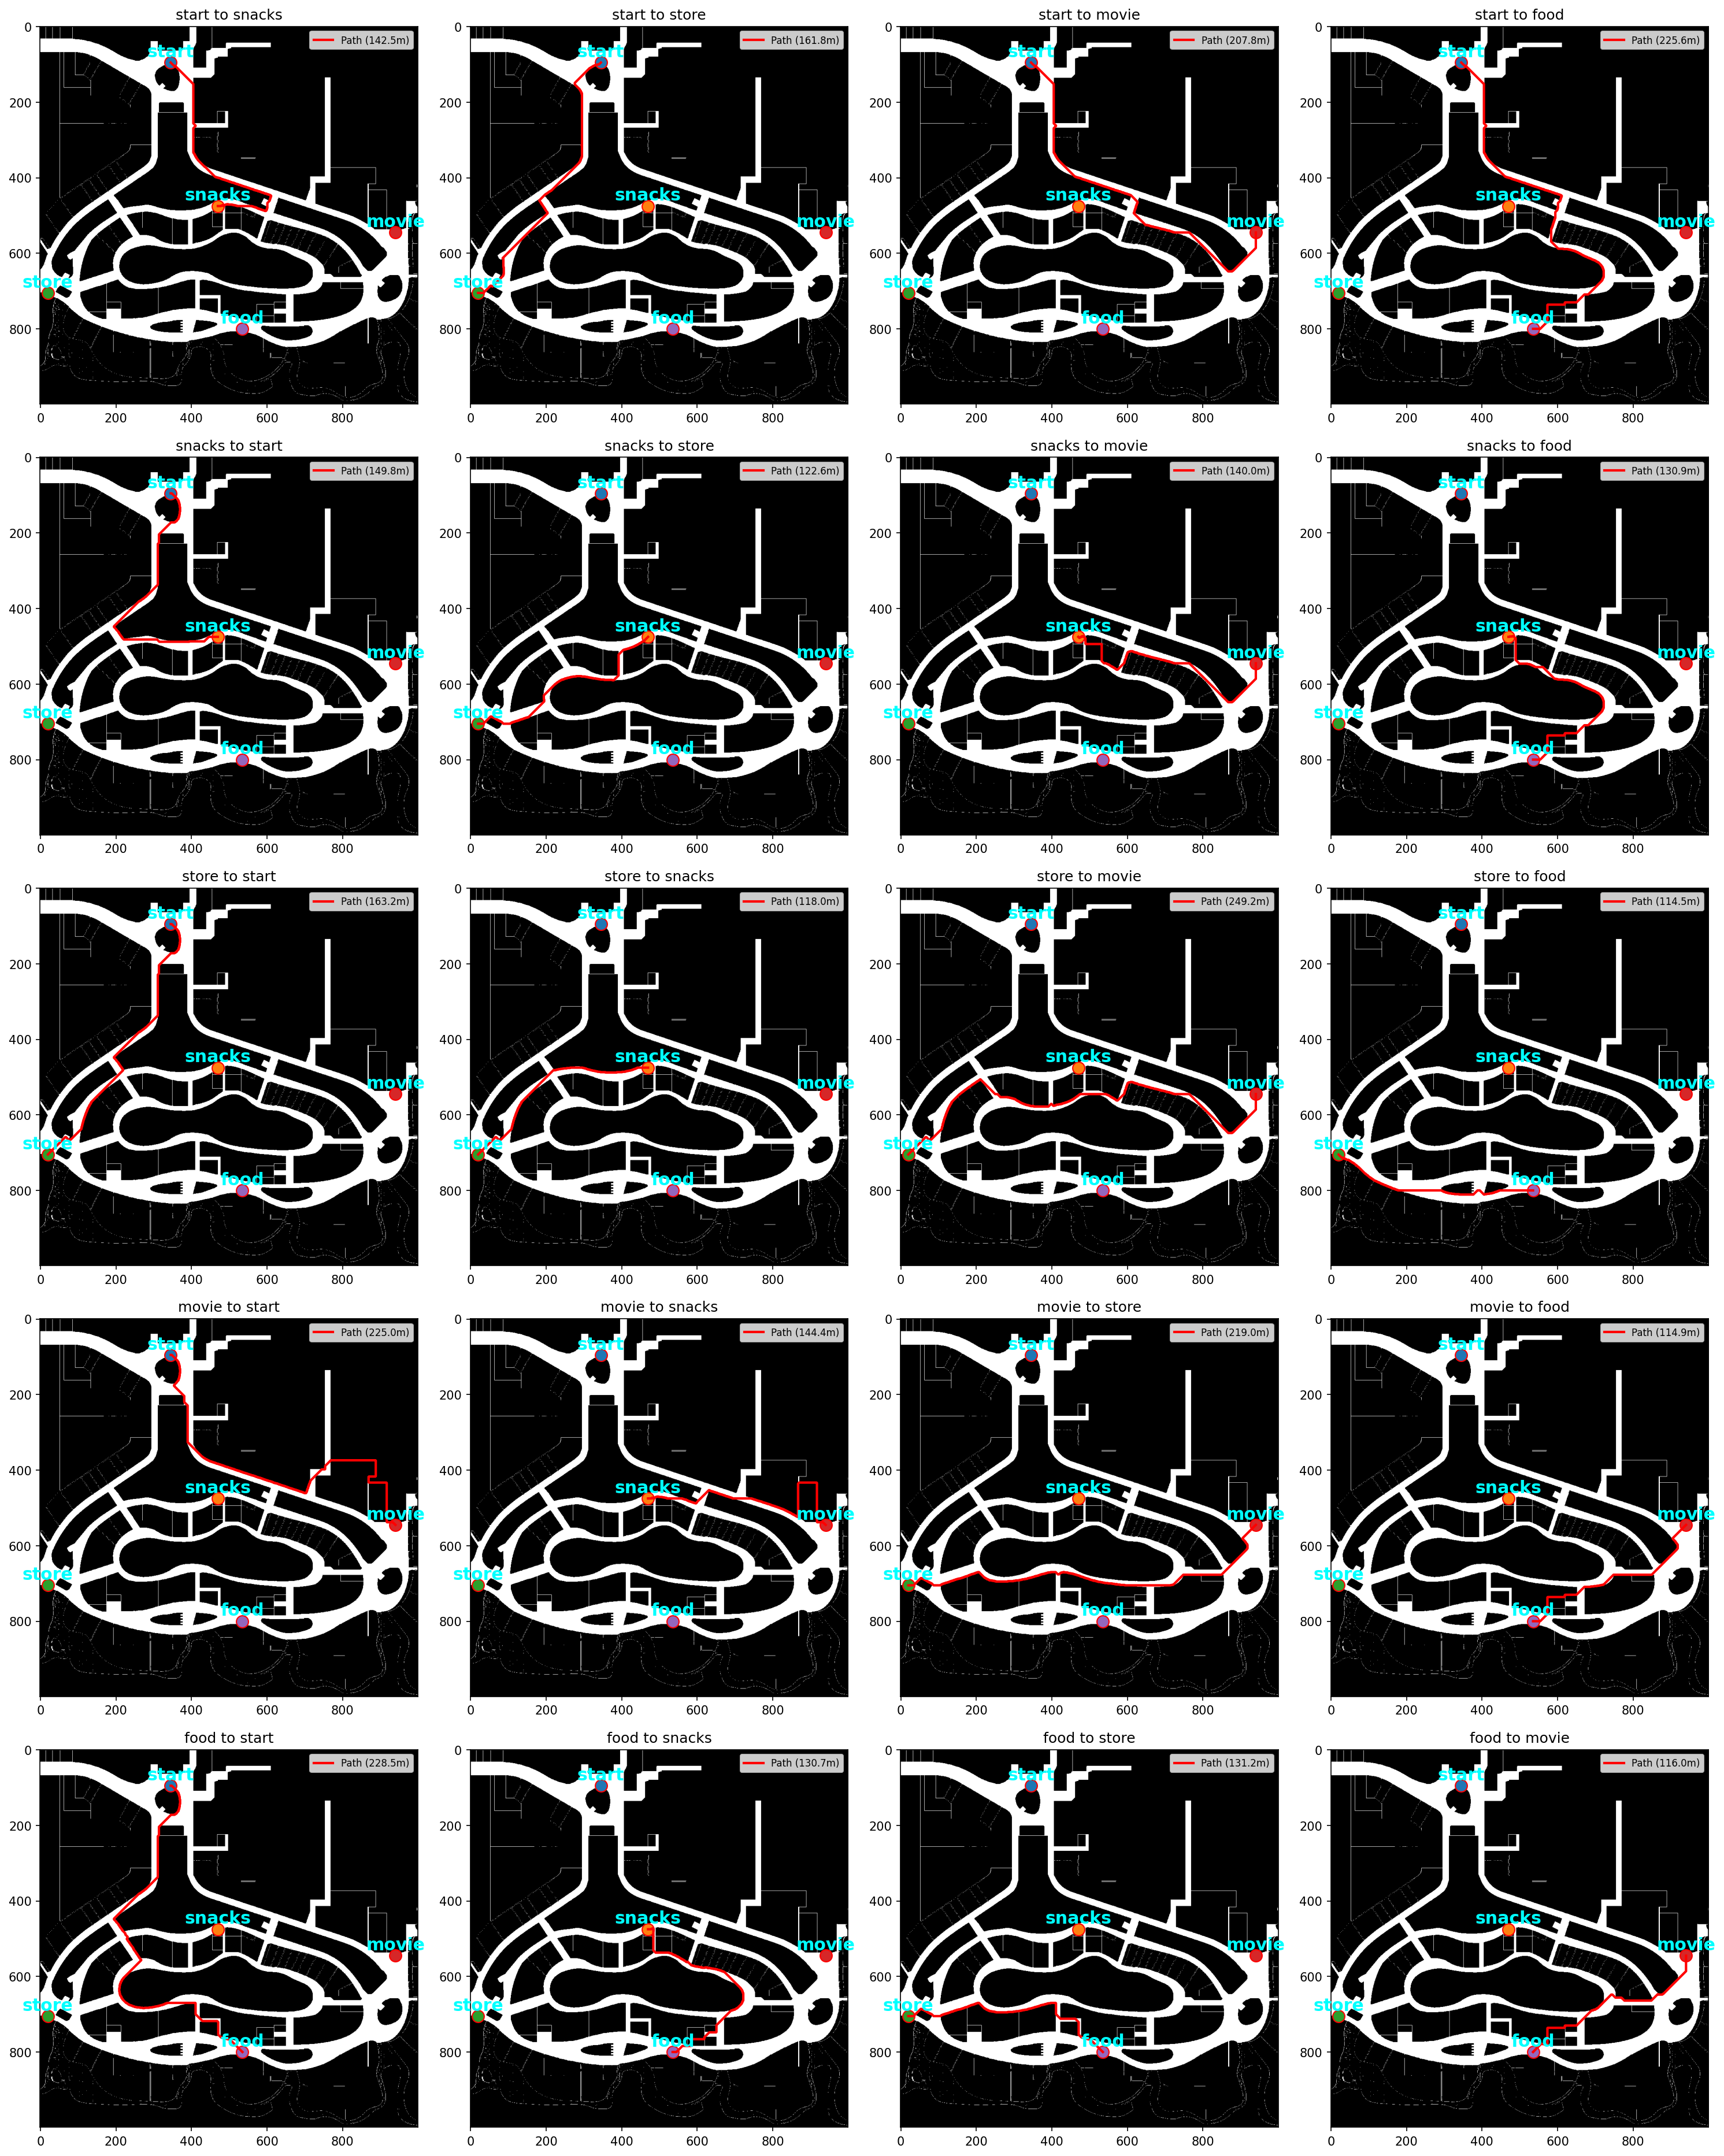

In [4]:
import time
import itertools

# Locations on the map
locations_list = ['start', 'snacks', 'store', 'movie', 'food']
# Create all combinations of locations
combinations = [(start, end) for start, end in itertools.permutations(locations_list, 2)]

n_rows, n_cols = 5, 4
plt.figure(figsize=(20, 25), dpi=150)

# Iterate through all combinations of locations
for idx, (start_loc, end_loc) in enumerate(combinations):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations, color='cyan')
    
    start_pos = locations[start_loc]
    goal_pos = locations[end_loc]
    
    start_time = time.time()
    path = astar(grid_map, start_pos, goal_pos)
    end_time = time.time()
    
    if path:
        path_length = calculate_path_length(path, MAP_RES)
        print(f"\nPath found from {start_loc} to {end_loc}:")
        print(f"- Steps: {len(path)}")
        print(f"- Length: {path_length:.1f} meters")
        print(f"- Time: {(end_time - start_time)*1000:.2f} ms")
        path = np.array(path)
        plt.plot(path[:,0], path[:,1], 'r-', linewidth=2, label=f'Path ({path_length:.1f}m)')
    
    plt.title(f"{start_loc} to {end_loc}", fontsize=12)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()       


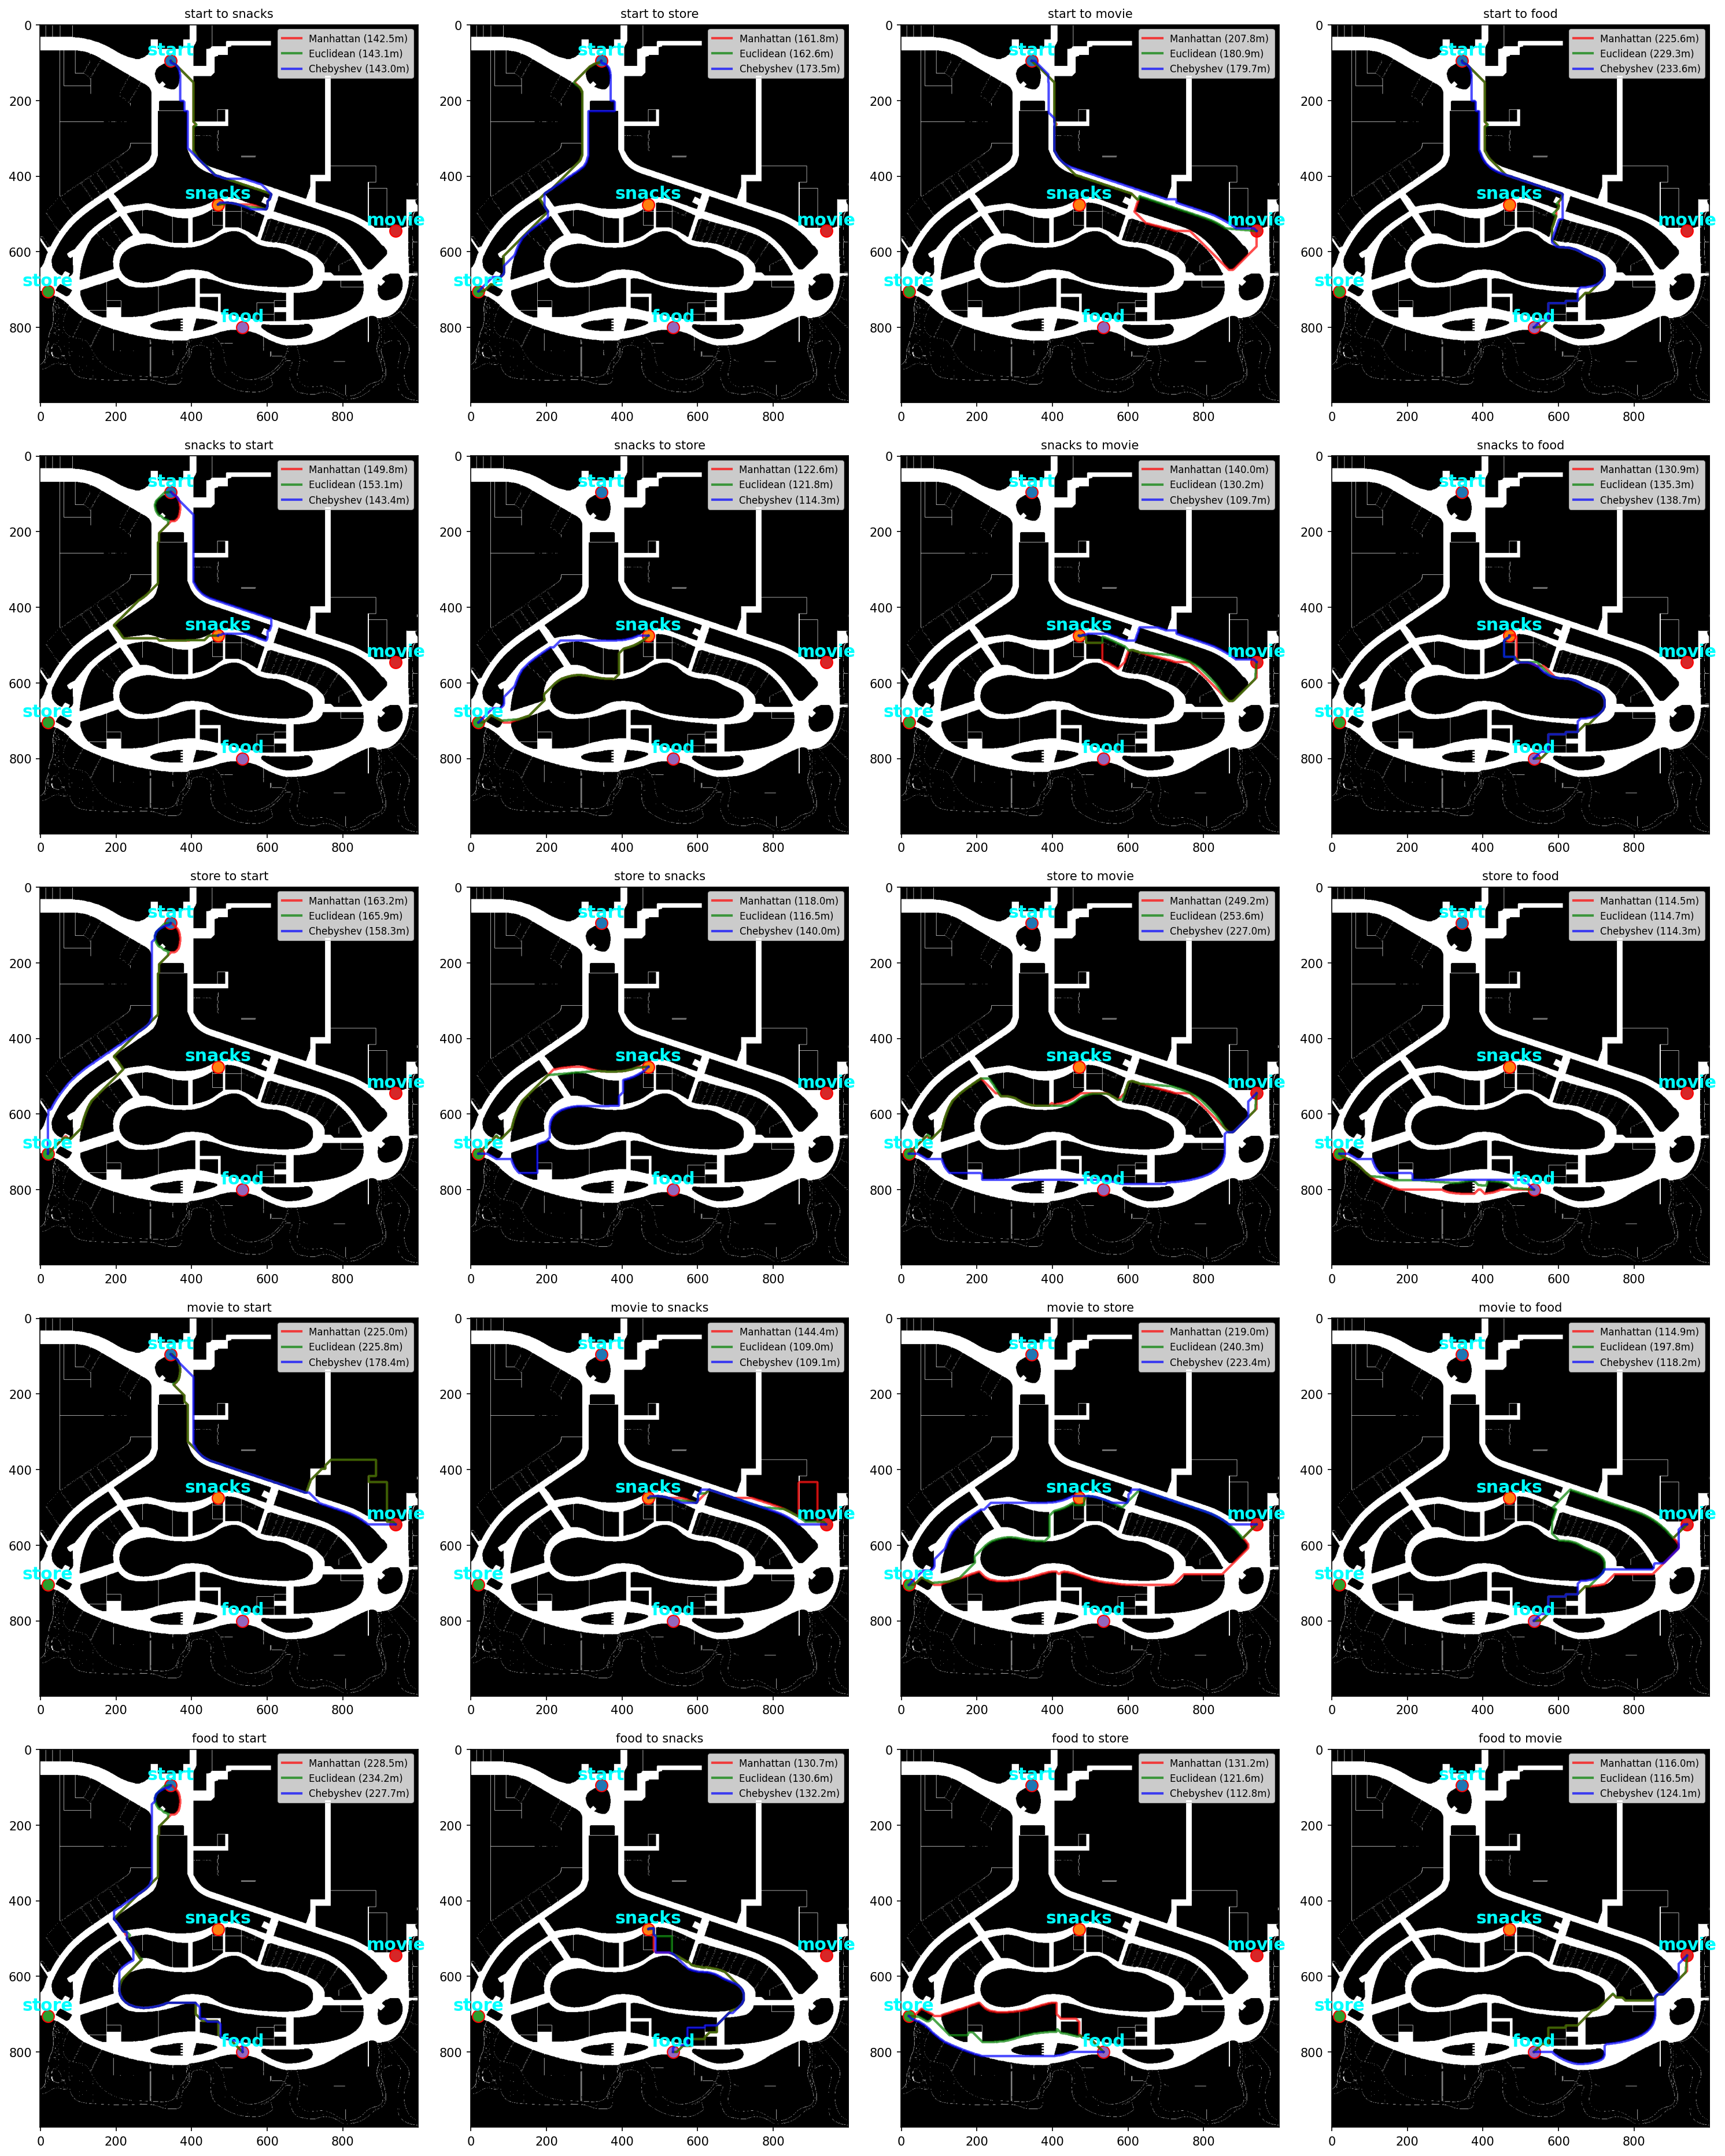

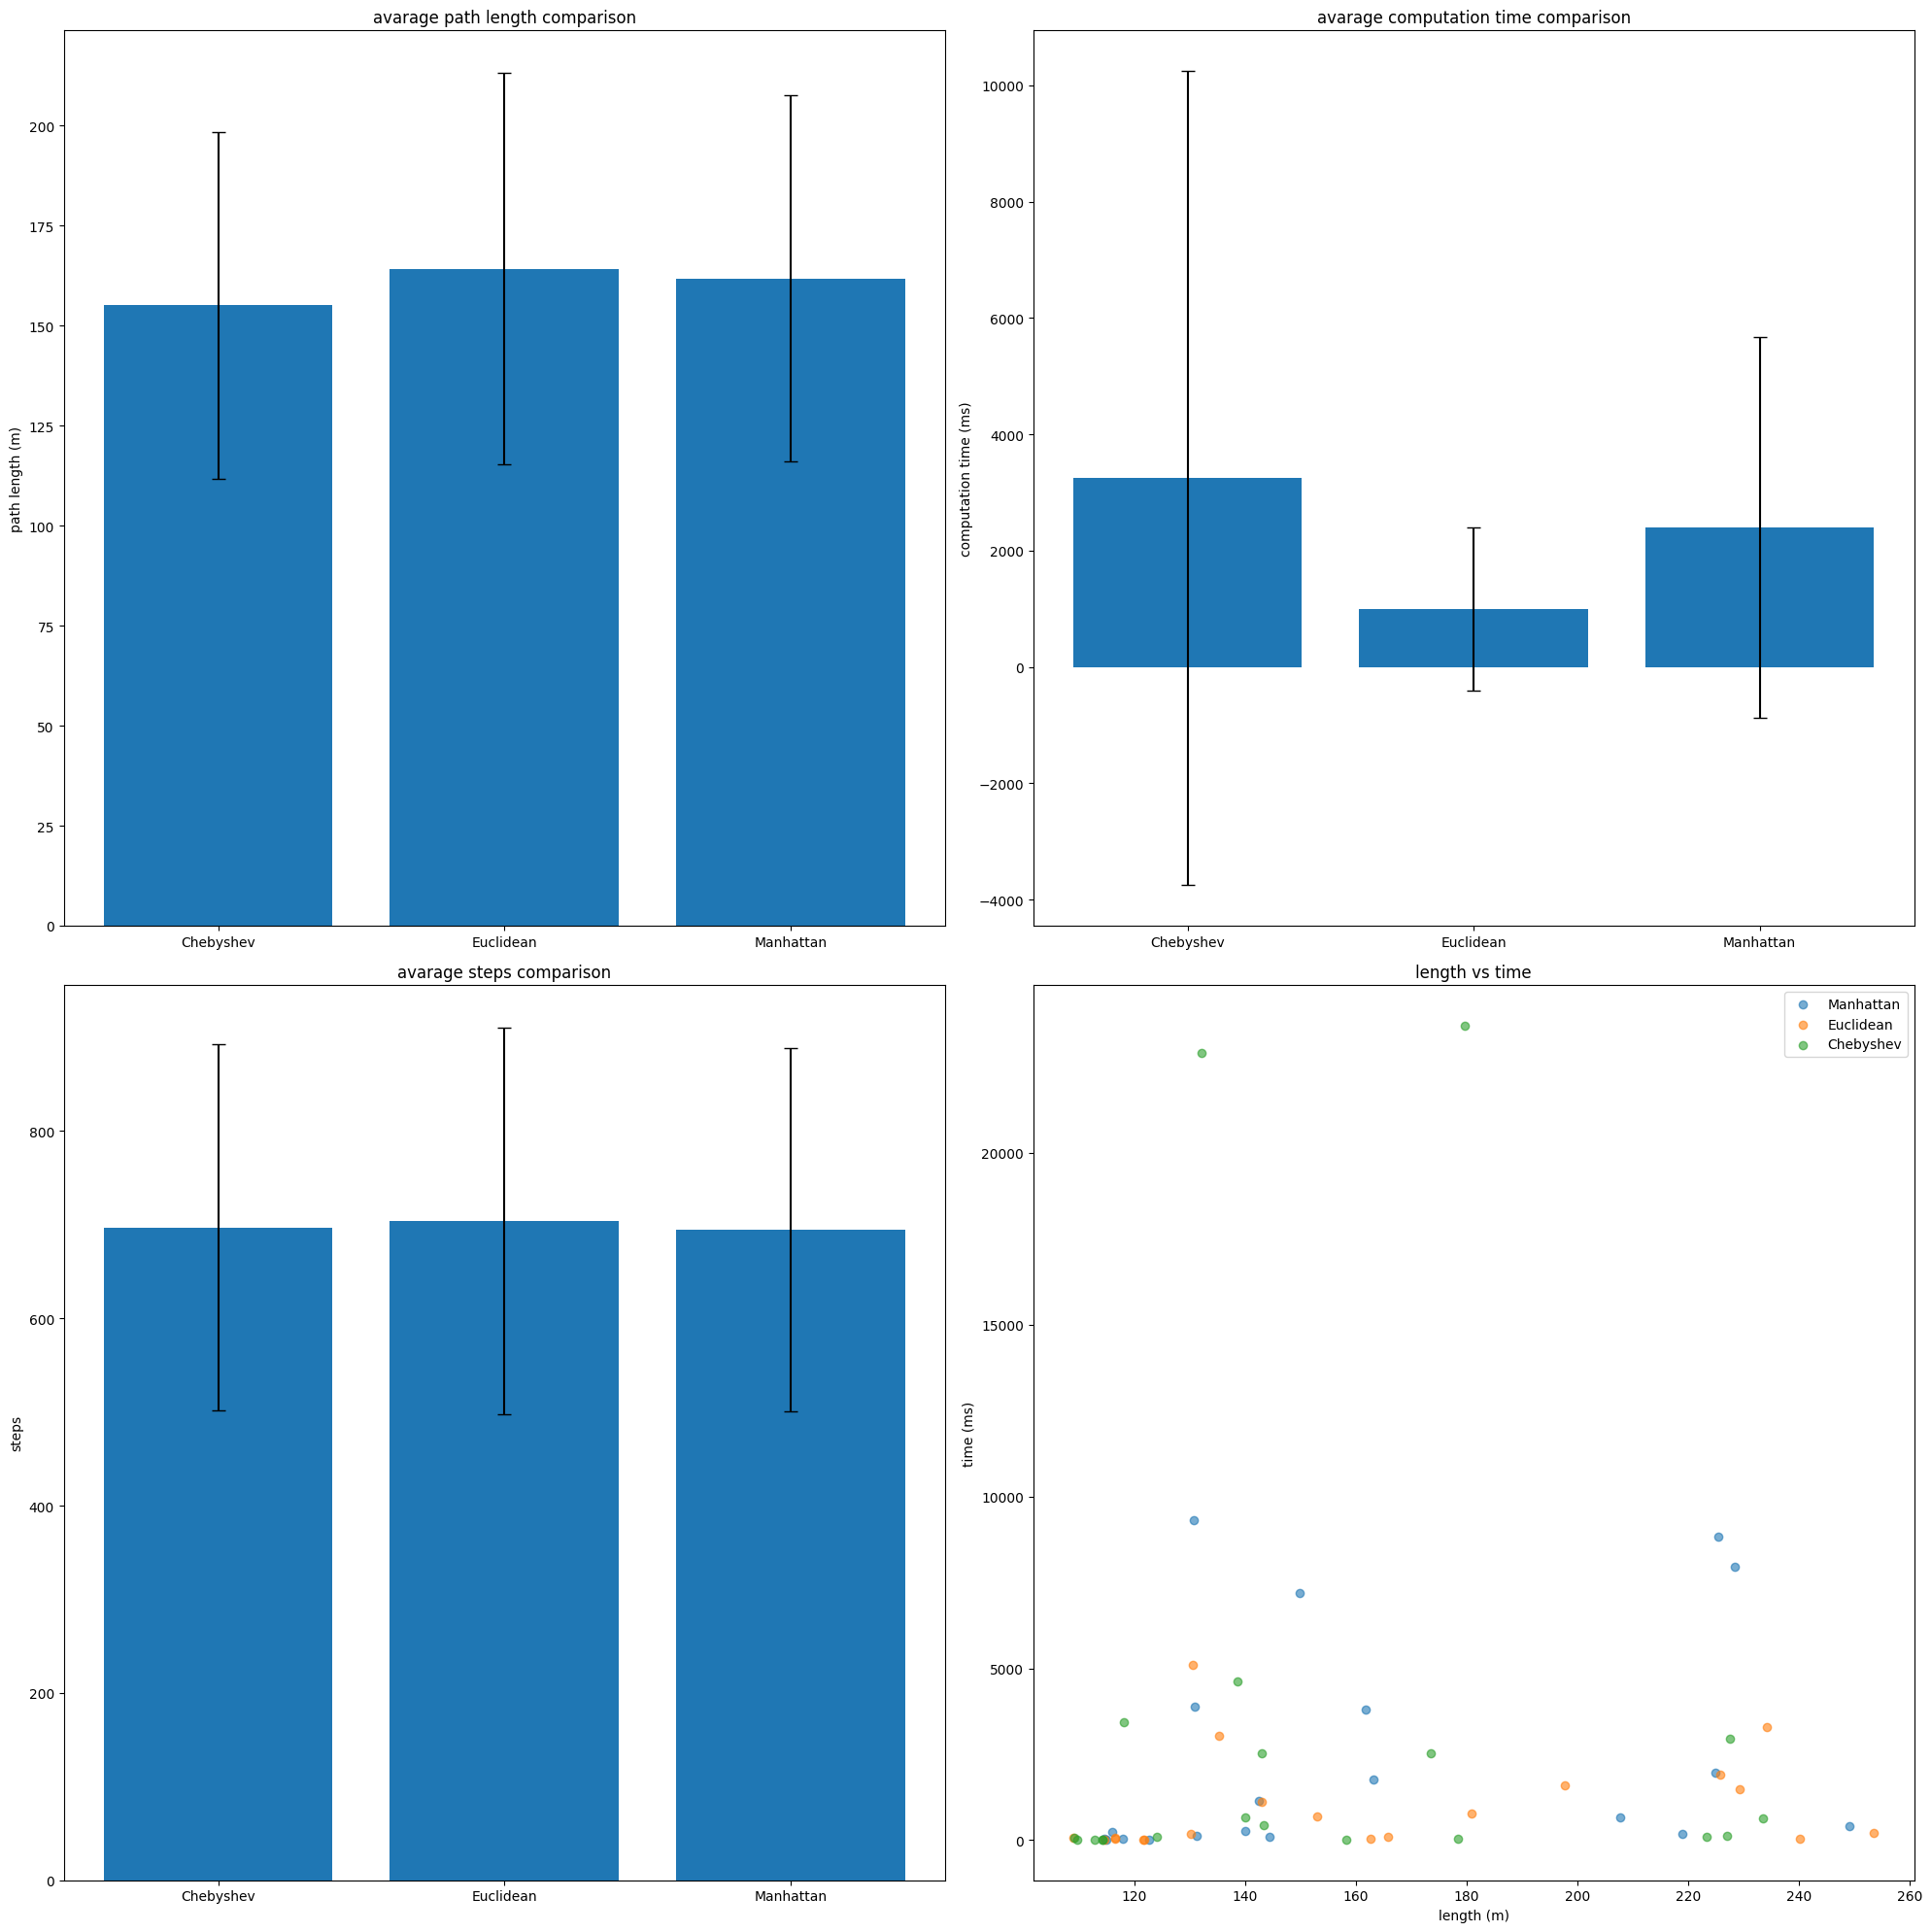


=== Analysis of A* Path Planning ===

Manhattan heuristic function:
average path length: 161.77m
average computation time: 2399.40ms
average steps: 694.50
----------------------------------------

Euclidean heuristic function:
average path length: 164.15m
average computation time: 992.30ms
average steps: 703.95
----------------------------------------

Chebyshev heuristic function:
average path length: 155.07m
average computation time: 3247.88ms
average steps: 697.20
----------------------------------------

=== Best and Worst Cases ===

Manhattan heuristic function:
shortest path:
- store -> food: 114.52m
longest path:
- store -> movie: 249.16m

Euclidean heuristic function:
shortest path:
- movie -> snacks: 108.96m
longest path:
- store -> movie: 253.65m

Chebyshev heuristic function:
shortest path:
- movie -> snacks: 109.12m
longest path:
- start -> food: 233.60m


In [6]:
import time
import itertools
import pandas as pd
import numpy as np

# all locations
locations_list = ['start', 'snacks', 'store', 'movie', 'food']
combinations = [(start, end) for start, end in itertools.permutations(locations_list, 2)]

# define heuristics
heuristics = {
    "Manhattan": heuristic_manhattan,
    "Euclidean": heuristic_euclidean,
    "Chebyshev": heuristic_chebyshev
}

# create a list to store the results
paths_data = []

# calculate paths for all combinations
for start_loc, end_loc in combinations:
    start_pos = locations[start_loc]
    goal_pos = locations[end_loc]
    
    for h_name, h_func in heuristics.items():
        path, comp_time = astar_with_heuristic(grid_map, start_pos, goal_pos, h_func)
        
        if path:
            path_length = calculate_path_length(path, MAP_RES)
            paths_data.append({
                'Start': start_loc,
                'End': end_loc,
                'Heuristic': h_name,
                'Length (m)': path_length,
                'Steps': len(path),
                'Time (ms)': comp_time
            })

# create a DataFrame from the results
df = pd.DataFrame(paths_data)

# visualize the paths
plt.figure(figsize=(20, 25),dpi=150)
colors = {'Manhattan': 'r', 'Euclidean': 'g', 'Chebyshev': 'b'}

for idx, (start_loc, end_loc) in enumerate(combinations):
    plt.subplot(5, 4, idx+1)
    plt.imshow(grid_map_img, cmap='gray')
    plot_locations(locations, color='cyan')
    
    for h_name, h_func in heuristics.items():
        path, _ = astar_with_heuristic(grid_map, locations[start_loc], locations[end_loc], h_func)
        if path:
            path_length = calculate_path_length(path, MAP_RES)
            path = np.array(path)
            plt.plot(path[:,0], path[:,1], colors[h_name], linewidth=2, label=f'{h_name} ({path_length:.1f}m)', alpha=0.7)
            
    
    plt.title(f'{start_loc} to {end_loc}', fontsize=10)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# create a figure to visualize the results
plt.figure(figsize=(20, 20))

# 1. calculate path length comparison
plt.subplot(2, 2, 1)
df_grouped = df.groupby('Heuristic')['Length (m)'].agg(['mean', 'std']).reset_index()
plt.bar(df_grouped['Heuristic'], df_grouped['mean'], yerr=df_grouped['std'], capsize=5)
plt.title('avarage path length comparison')
plt.ylabel('path length (m)')

# 2. calculate computation time comparison
plt.subplot(2, 2, 2)
df_grouped = df.groupby('Heuristic')['Time (ms)'].agg(['mean', 'std']).reset_index()
plt.bar(df_grouped['Heuristic'], df_grouped['mean'], yerr=df_grouped['std'], capsize=5)
plt.title('avarage computation time comparison')
plt.ylabel('computation time (ms)')

# 3. calculate steps comparison
plt.subplot(2, 2, 3)
df_grouped = df.groupby('Heuristic')['Steps'].agg(['mean', 'std']).reset_index()
plt.bar(df_grouped['Heuristic'], df_grouped['mean'], yerr=df_grouped['std'], capsize=5)
plt.title('avarage steps comparison')
plt.ylabel('steps')

# 4. calculate length vs time
plt.subplot(2, 2, 4)
for h_name in heuristics:
    mask = df['Heuristic'] == h_name
    plt.scatter(df[mask]['Length (m)'], df[mask]['Time (ms)'], 
               label=h_name, alpha=0.6)
plt.xlabel('length (m)')
plt.ylabel('time (ms)')
plt.title('length vs time')
plt.legend()

plt.tight_layout()
plt.show()

# print the DataFrame
print("\n=== Analysis of A* Path Planning ===")
for h_name in heuristics.keys():
    h_data = df[df['Heuristic'] == h_name]
    print(f"\n{h_name} heuristic function:")
    print(f"average path length: {h_data['Length (m)'].mean():.2f}m")
    print(f"average computation time: {h_data['Time (ms)'].mean():.2f}ms")
    print(f"average steps: {h_data['Steps'].mean():.2f}")
    print("-" * 40)

# find the best and worst cases
print("\n=== Best and Worst Cases ===") 
for h_name in heuristics.keys():
    h_data = df[df['Heuristic'] == h_name]
    print(f"\n{h_name} heuristic function:")
    print("shortest path:")
    min_length = h_data.loc[h_data['Length (m)'].idxmin()]
    print(f"- {min_length['Start']} -> {min_length['End']}: {min_length['Length (m)']:.2f}m")
    print("longest path:")
    max_length = h_data.loc[h_data['Length (m)'].idxmax()]
    print(f"- {max_length['Start']} -> {max_length['End']}: {max_length['Length (m)']:.2f}m")

## Task 2

Best path (Manhattan heuristic): start -> store -> food -> movie -> snacks -> start
Total distance: 686.56m
Computation time: 296278.69ms



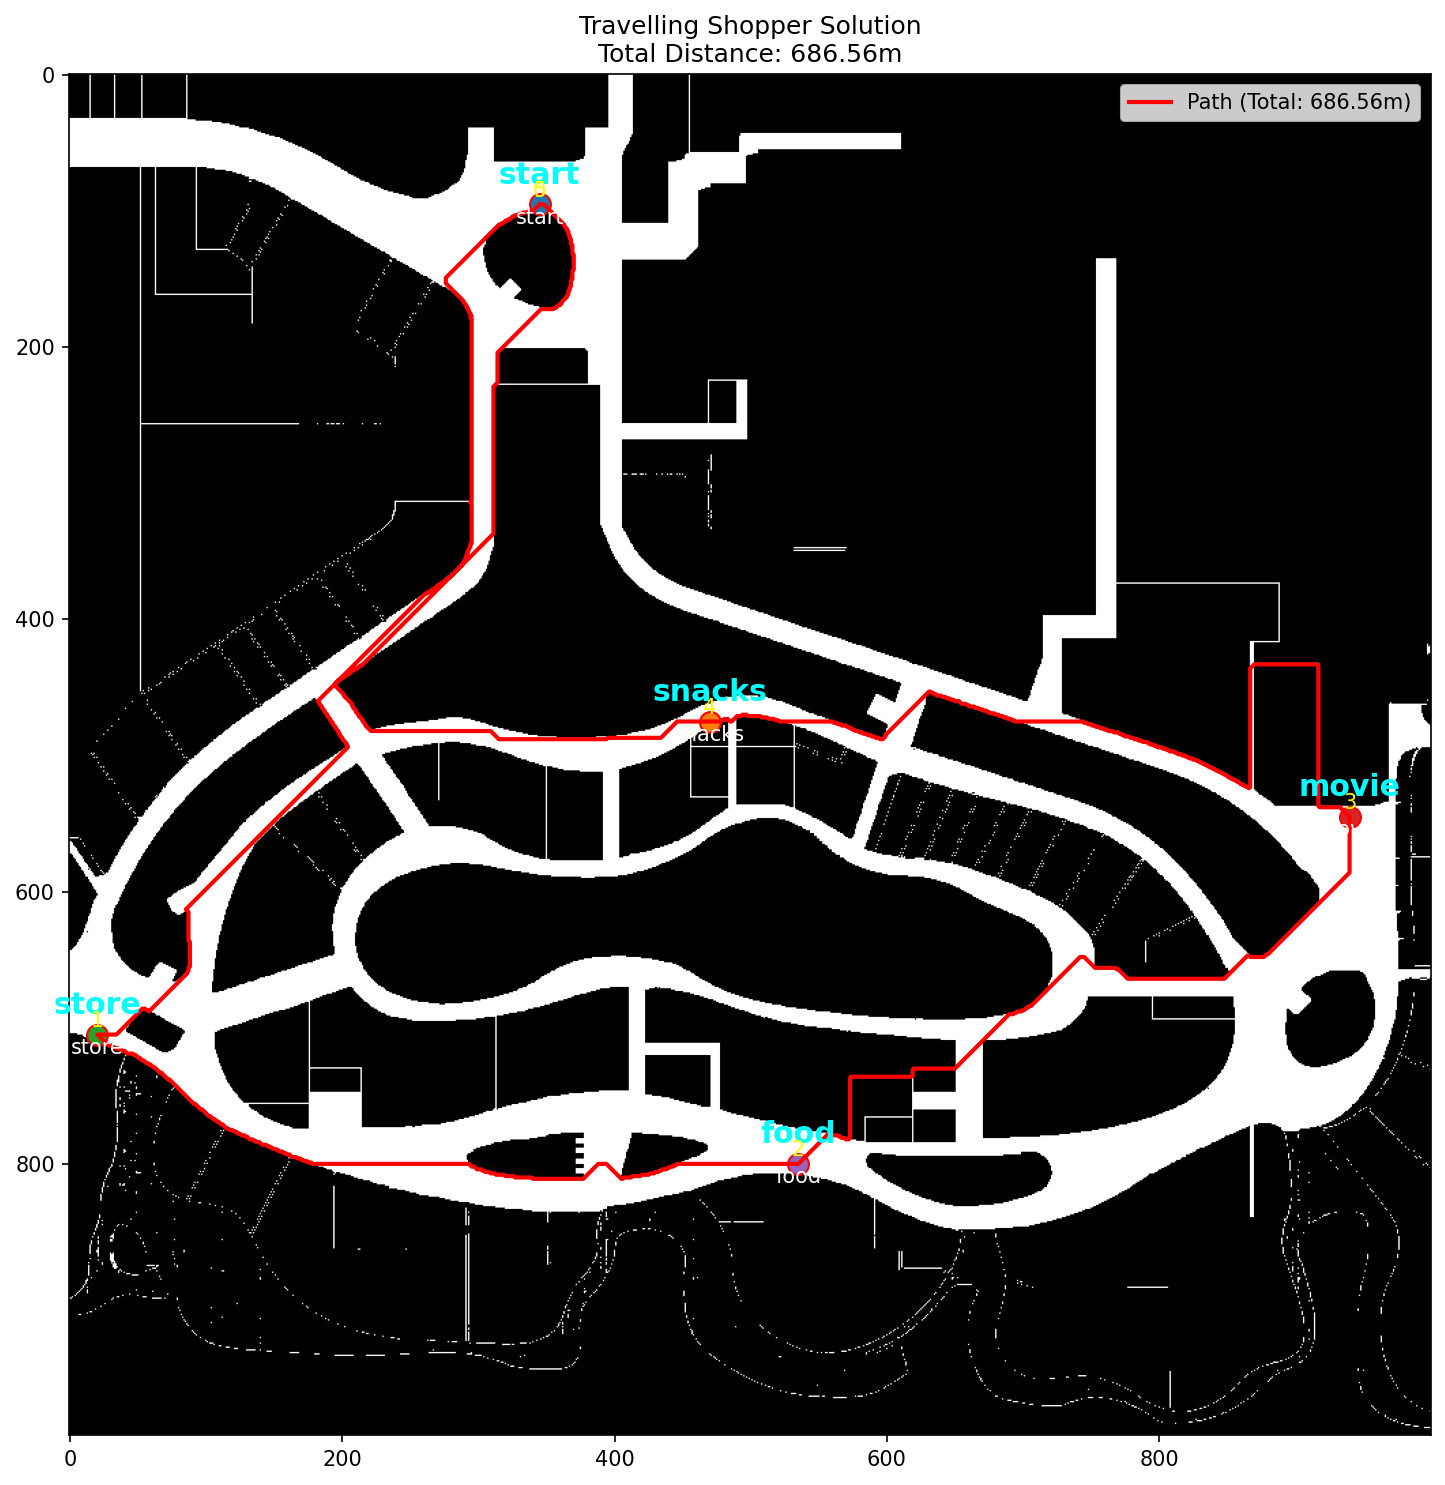

Best path (Greedy heuristic): start -> snacks -> store -> food -> movie -> start
Total distance: 720.71m
Computation time: 49581.70ms



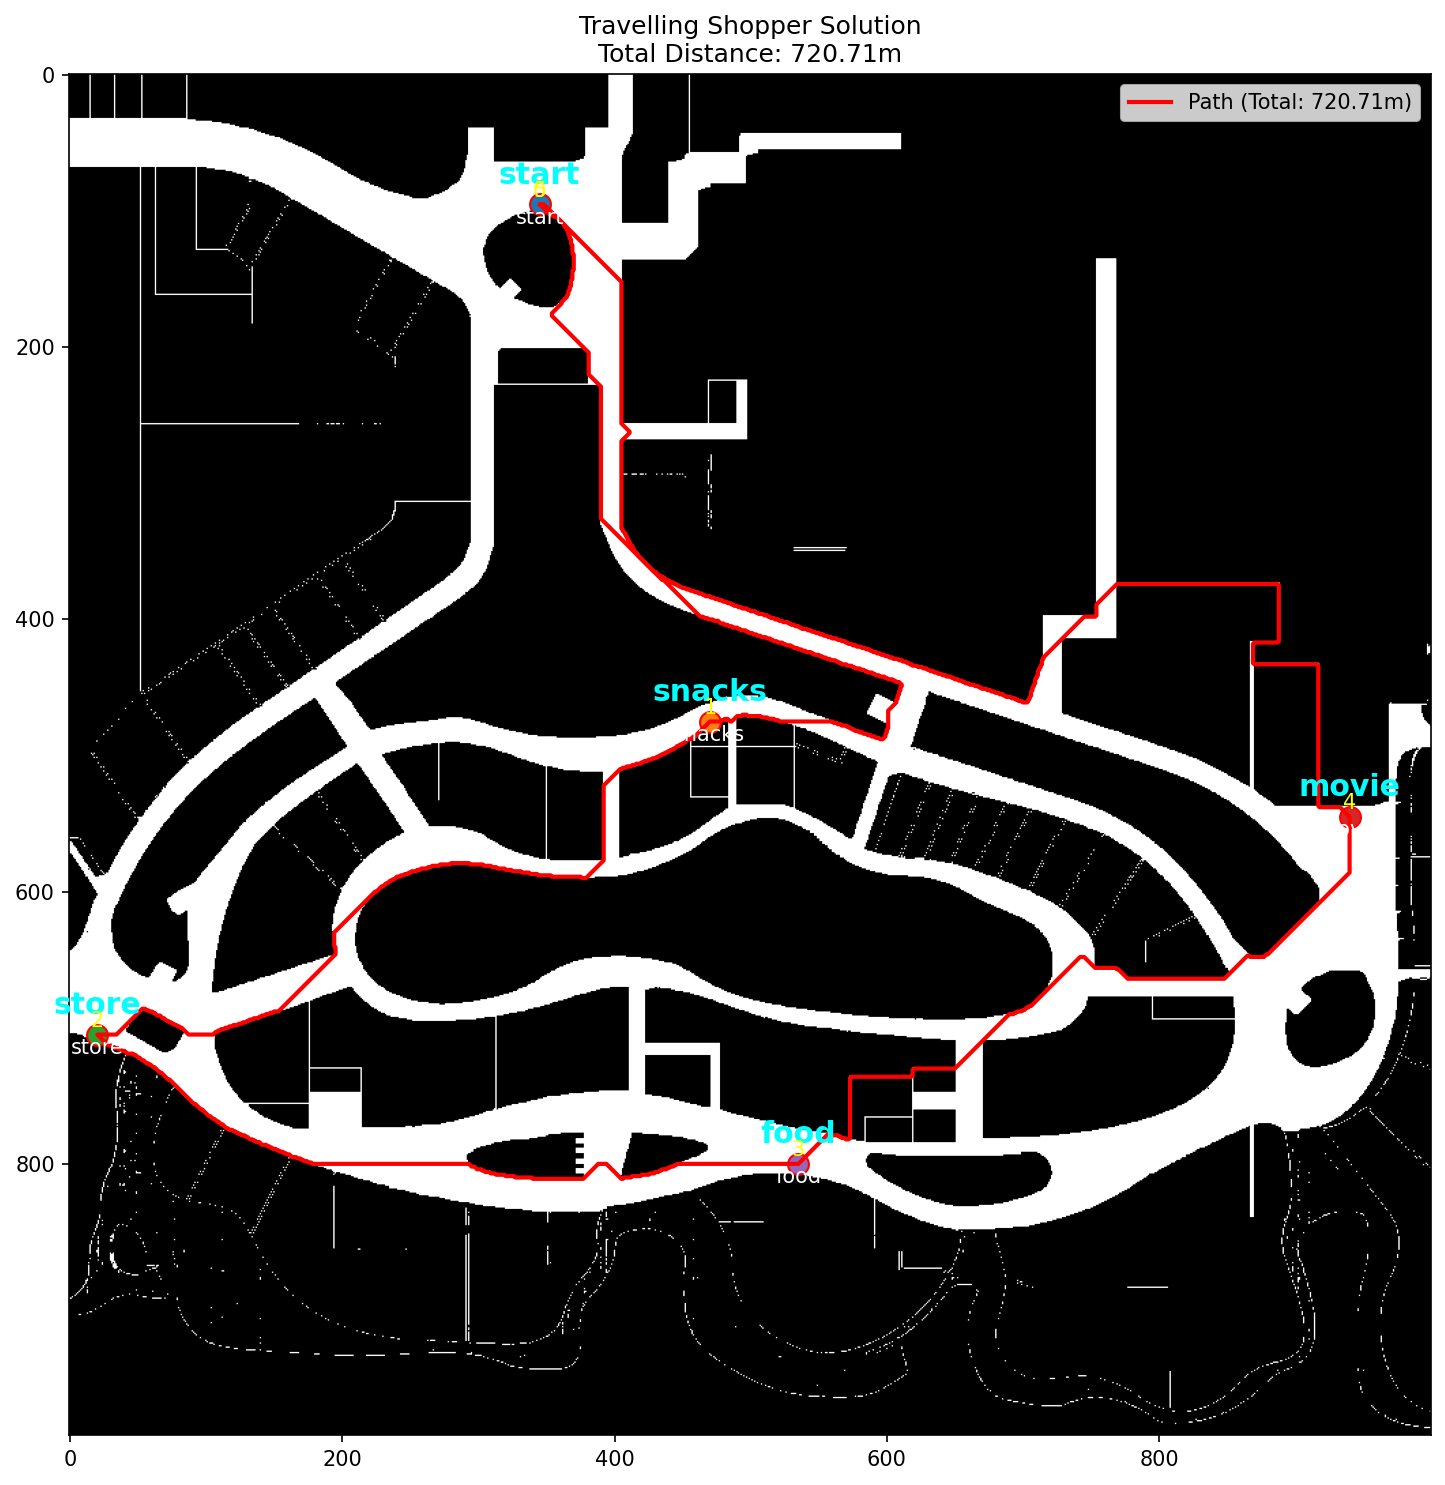

In [8]:
# Task 2 (Bonus): The "Travelling Shopper" Problem
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
import heapq

def Brute_Force_tsp(grid_map, locations, start_loc="start", heuristic_func=None, must_visit=None, return_to_start=True):
    """
    Solve the Travelling Shopper Problem using A* algorithm.
    
    Args:
        grid_map: 2D numpy array representing the map (0 for free space, 1 for obstacles)
        locations: Dictionary mapping location names to (x, y) coordinates
        start_loc: Name of the starting location
        heuristic_func: Heuristic function to use for A* algorithm
        must_visit: List of location names that must be visited (if None, visit all locations)
        return_to_start: Boolean indicating whether to return to start location
    
    Returns:
        best_path: List of location names in the best order to visit
        total_distance: Total distance of the best path
        complete_path: List of coordinate points for the complete path
    """
    start_time = time.time()
    
    # If no heuristic function is provided, use Euclidean distance
    if heuristic_func is None:
        heuristic_func = heuristic_euclidean
    
    # If must_visit is None, visit all locations except the start
    if must_visit is None:
        must_visit = [loc for loc in locations.keys() if loc != start_loc]
    
    # Add start location as the return destination if required
    if return_to_start:
        end_loc = start_loc
    else:
        end_loc = None
    
    # Generate all possible permutations of locations to visit
    permutations = list(itertools.permutations(must_visit))
    
    best_distance = float('inf')
    best_path_locations = None
    best_complete_path = None
    
    # Try each permutation
    for perm in permutations:
        # Add start location at the beginning
        path = [start_loc] + list(perm)
        
        # Add start location at the end if required
        if return_to_start:
            path.append(start_loc)
        
        # Calculate total path distance for this permutation
        total_distance = 0
        complete_path = []
        
        # Flag to check if the path is valid
        valid_path = True
        
        # Calculate A* path between consecutive locations
        for i in range(len(path) - 1):
            start_pos = locations[path[i]]
            goal_pos = locations[path[i+1]]
            
            # Use A* to find the path between these two locations
            a_star_path, _ = astar_with_heuristic(grid_map, start_pos, goal_pos, heuristic_func)
            
            # If no path is found between any two locations, this permutation is invalid
            if not a_star_path:
                valid_path = False
                break
            
            # Calculate path length and add to total
            path_length = calculate_path_length(a_star_path, MAP_RES)
            total_distance += path_length
            
            # Add the path to the complete path (excluding the first point to avoid duplicates)
            if i == 0:
                complete_path.extend(a_star_path)
            else:
                complete_path.extend(a_star_path[1:])
        
        # Update best path if this one is better
        if valid_path and total_distance < best_distance:
            best_distance = total_distance
            best_path_locations = path
            best_complete_path = complete_path
    
    computation_time = (time.time() - start_time) * 1000  # in milliseconds
    
    return best_path_locations, best_distance, best_complete_path, computation_time

import numpy as np
import heapq
import time

def greedy_tsp(grid_map, locations, start_loc="start", heuristic_func=None, return_to_start=True):
    """
    Solve TSP using Nearest Neighbor Heuristic (Greedy Approach).
    
    Args:
        grid_map: 2D numpy array representing the map (0 = free, 1 = obstacle).
        locations: Dictionary mapping location names to (x, y) coordinates.
        start_loc: Name of the starting location.
        heuristic_func: Heuristic function to use for A* algorithm.
        return_to_start: Whether to return to start location at the end.
    
    Returns:
        best_path_locations: List of location names in visit order.
        best_distance: Total path distance.
        best_complete_path: List of coordinate points for the complete path.
        computation_time: Time taken to compute the solution (in milliseconds).
    """
    start_time = time.time()
    
    if heuristic_func is None:
        heuristic_func = heuristic_euclidean  # Default to Euclidean heuristic
    
    # Step 1: Compute distance matrix using A*
    loc_names = list(locations.keys())
    n = len(loc_names)
    distance_matrix = np.full((n, n), np.inf)
    path_matrix = [[None] * n for _ in range(n)]
    
    for i, loc1 in enumerate(loc_names):
        for j, loc2 in enumerate(loc_names):
            if i != j:
                path, _ = astar_with_heuristic(grid_map, locations[loc1], locations[loc2], heuristic_func)
                if path:
                    distance_matrix[i][j] = calculate_path_length(path, MAP_RES)
                    path_matrix[i][j] = path
    
    # Step 2: Perform Greedy TSP
    start_idx = loc_names.index(start_loc)
    visited = set([start_idx])
    path_order = [start_idx]
    total_distance = 0
    best_complete_path = []
    
    current_idx = start_idx
    while len(visited) < n:
        # Find nearest unvisited location
        nearest_idx = None
        nearest_dist = np.inf
        
        for i in range(n):
            if i not in visited and distance_matrix[current_idx][i] < nearest_dist:
                nearest_idx = i
                nearest_dist = distance_matrix[current_idx][i]
        
        if nearest_idx is None:  # No valid next step
            break
        
        # Move to the nearest location
        path_order.append(nearest_idx)
        visited.add(nearest_idx)
        total_distance += nearest_dist
        
        # Add path to complete path
        best_complete_path.extend(path_matrix[current_idx][nearest_idx][1:])
        
        current_idx = nearest_idx
    
    # Return to start if required
    if return_to_start and len(path_order) > 1:
        total_distance += distance_matrix[current_idx][start_idx]
        path_order.append(start_idx)
        best_complete_path.extend(path_matrix[current_idx][start_idx][1:])
    
    best_path_locations = [loc_names[i] for i in path_order]
    computation_time = (time.time() - start_time) * 1000  # in milliseconds
    
    return best_path_locations, total_distance, best_complete_path, computation_time



# Function to visualize the travelling shopper solution
def visualize_travelling_shopper(grid_map_img, locations, best_path, complete_path, total_distance):
    plt.figure(figsize=(10, 10), dpi=150)
    plt.imshow(grid_map_img, cmap='gray')
    
    # Plot locations
    plot_locations(locations, color='cyan')
    
    # Plot the complete path
    path = np.array(complete_path)
    plt.plot(path[:,0], path[:,1], 'r-', linewidth=2, label=f'Path (Total: {total_distance:.2f}m)')
    
    # Add location labels
    for loc, (x, y) in locations.items():
        plt.text(x, y+10, loc, color='white', fontsize=10, 
                 horizontalalignment='center', verticalalignment='center')
    
    # Add order labels for the path
    for i, loc in enumerate(best_path):
        x, y = locations[loc]
        plt.text(x, y-10, str(i), color='yellow', fontsize=10, 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.title(f'Travelling Shopper Solution\nTotal Distance: {total_distance:.2f}m')
    plt.legend()
    plt.tight_layout()
    plt.show()


# define heuristics
heuristics = {
    "Manhattan": heuristic_manhattan,
    "Euclidean": heuristic_euclidean,
    "Chebyshev": heuristic_chebyshev
}

# solve the Travelling Shopper Problem using Brute Force
best_path, total_distance, complete_path, comp_time = Brute_Force_tsp(
    grid_map, locations, "start", heuristic_manhattan)

print(f"Best path (Manhattan heuristic): {' -> '.join(best_path)}")
print(f"Total distance: {total_distance:.2f}m")
print(f"Computation time: {comp_time:.2f}ms\n")

# Visualize the solution
visualize_travelling_shopper(grid_map_img, locations, best_path, complete_path, total_distance)

# solve the Travelling Shopper Problem using Greedy TSP
best_path1, total_distance1, complete_path1, comp_time1 = greedy_tsp(
    grid_map, locations, "start", heuristic_manhattan)
print(f"Best path (Greedy heuristic): {' -> '.join(best_path1)}")
print(f"Total distance: {total_distance1:.2f}m")
print(f"Computation time: {comp_time1:.2f}ms\n")
# Visualize the solution
visualize_travelling_shopper(grid_map_img, locations, best_path1, complete_path1, total_distance1)


## Task3

- [github link]()